### TensorFlow利用卷积神经网络实现CIFAR-10图像识别

使用卷积神经网络对CIFAR-10数据集进行图像识别。

**CIFAR-10数据集**

`CIFAR-10`是由`Alex Krizhevsky`,`Vinod Nair`和`Geoffrey Hinton`收集而来的用于图像识别的数据集，它一共有10个分类，每个分类有6000张32×32大小的彩色图像，所以一共有60000张图像，其中50000张用于训练，10000用于测试。

<img src="https://blobscdn.gitbook.com/v0/b/gitbook-28427.appspot.com/o/assets%2F-LYtTdBhaX9EsGjMVkHV%2F-LaNQHeKOfKnWqP40HBJ%2F-LaNbtucXS64EvUAH15B%2Fimage.png?alt=media&token=2559fa46-040f-4c74-adb4-11fc5f1367ec" width=500>

**CIFAR-10数据集**

In [1]:
import urllib.request
import os
import tarfile

# 下载
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
filepath = "data/cifar-10-python.tar.gz"
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url,filepath)
    print("downloaded:",result)
else:
    print("Data file already exists.")
    
# 解压
if not os.path.exists("data/cifar-10-batches-py"):
    tfile = tarfile.open("data/cifar-10-python.tar.gz","r:gz")
    result = tfile.extractall("data/")
    print("Extracted to ./data/cifar-10-batches-py/")
else:
    print("Directory already exists")

Data file already exists.
Directory already exists


**导入CIFAR-10数据集**

在下载和解压之后，我们需要读取训练数据和测试数据。

在这里，定义了两个函数:load_CIFAR_batch()和load_CIFAR_data()

load_CIFAR_batch()读取一个批次的样本  load_CIFAR_data()实现数据集的完整读取

In [2]:
import os
import numpy as np
import pickle as p

def load_CIFAR_batch(filename):
    """ load single batch of cifar """  
    with open(filename,"rb") as f:
        # 一个样本由标签和图像数据组成
        # <1 x label><3072 x pixel> (3072=32x32x3)
        # ...
        # <1 x label><3072 x pixel>
        data_dict = p.load(f,encoding="bytes")
        images = data_dict[b"data"]
        labels = data_dict[b"labels"]
        
        # 原始数据结构调整为
        images = images.reshape(10000,3,32,32)
        images = images.transpose(0,2,3,1) # 把通道数据C移到最后一个维度
        
        labels = np.array(labels)
        
        return images,labels

def load_CIFAR_data(data_dir):
    """load CIFAR data"""
    
    images_train = []
    labels_train = []
    for i in range(5):
        f = os.path.join(data_dir,"data_batch_%d" %(i+1))
        print('loading ',f)
        # 调用 load_CIFAR_batch( )获得批量的图像及其对应的标签
        image_batch,label_batch=load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain=np.concatenate(images_train)
        Ytrain=np.concatenate(labels_train)
        del image_batch ,label_batch
    
    Xtest,Ytest=load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    # 返回训练集的图像和标签，测试集的图像和标签
    return Xtrain,Ytrain,Xtest,Ytest

data_dir = 'data/cifar-10-batches-py/'
Xtrain,Ytrain,Xtest,Ytest = load_CIFAR_data(data_dir)

loading  data/cifar-10-batches-py/data_batch_1
loading  data/cifar-10-batches-py/data_batch_2
loading  data/cifar-10-batches-py/data_batch_3
loading  data/cifar-10-batches-py/data_batch_4
loading  data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


每次读取10000条数据，所以load_CIFAR_data()通过一个for循环语句来循环地调用load_CIFAR_batch()，从而获取完整的数据集，最后返回的是训练集的图像和标签以及测试集的图像和标签。

**显示数据集信息**

In [3]:
print("training data shape:",Xtrain.shape)
print("training labels shape:",Ytrain.shape)
print("test data shape:",Xtest.shape)
print("test labels shape:",Ytest.shape)

training data shape: (50000, 32, 32, 3)
training labels shape: (50000,)
test data shape: (10000, 32, 32, 3)
test labels shape: (10000,)


训练集有50000条数据，测试集有10000条数据，图像的尺寸为32×32，通道为RGB三通道。

**查看单项image和label**

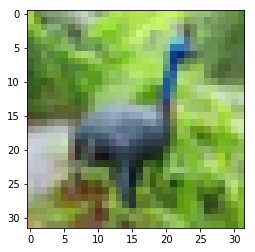

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# 查看image
plt.imshow(Xtrain[6])

**查看多项images和label**

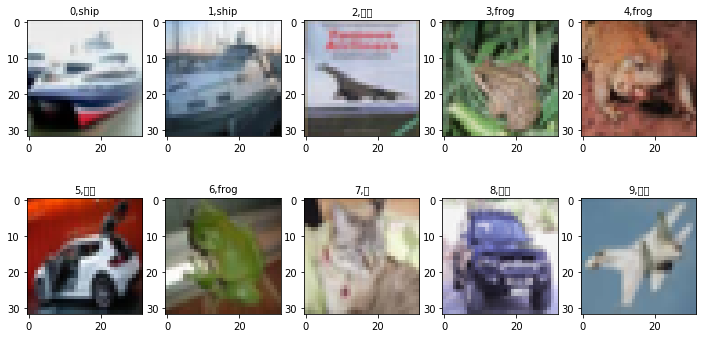

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

#定义标签字典，每一个数字所代表的图像类别的名称
label_dict={0:"飞机",1:"汽车",2:"鸟",3:"猫",4:"鹿",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

# 定义显示图像数据及其对应标签的函数
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    if num>10:
        num = 10
    for i in range(0,num):
        ax = plt.subplot(2,5,i+1)
        ax.imshow(images[idx],cmap="binary")
        
        title = str(i)+","+label_dict[labels[idx]]
        if len(prediction)>0:
            title += "=>"+label_dict[prediction[idx]]
        
        ax.set_title(title,fontsize=10)
        
        idx+=1
    plt.show()
    
# 显示图像数据集及其对应标签
plot_images_labels_prediction(Xtest,Ytest,[],1,10)

**数据预处理**

接下来，我们要对数据进行必要的预处理，这个数据包括图像数据和标签数据。

**图像数据预处理**

我们先查看一下第一个训练样本的第一个像素点

In [6]:
#x显示第一个图的第一个像素点
Xtrain[0][0][0]

array([59, 62, 63], dtype=uint8)

由于图像时三通道的，所以59,62,63这三个数分别代表了图像的第一个像素点在RGB三个通道上的像素值。

然后对图像进行标准化处理：

In [7]:
# 将图像进行数字标准化
Xtrain_normalize = Xtrain.astype("float32")/255.0
Xtest_normalize = Xtest.astype("float32")/255.0

In [8]:
# 查看预处理后图像数据信息
Xtrain_normalize[0][0][0]

array([ 0.23137255,  0.24313726,  0.24705882], dtype=float32)

**标签数据预处理**

In [9]:
# 查看标签数据
Ytrain[:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [10]:
# 独热编码
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]

encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1,1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1,1)
Ytest_onehot = encoder.transform(Ytest_reshape)

In [11]:
Ytrain_onehot.shape

(50000, 10)

在未进行独热编码之前，对于训练数据集，前五个样本所对应的标签是6,9,9,4,1

In [12]:
Ytrain[:5]

array([6, 9, 9, 4, 1])

在进行独热编码之后，它们所对应的标签就变成了下图的样子：

In [13]:
Ytrain_onehot[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

**建立CIFAR-10图像分类模型**

首先，导入需要的库

In [14]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


**定义模型**

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xtrain.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

**编译模型**

In [17]:
# train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])

**模型训练**

In [18]:
# 训练模型
history = model.fit(Xtrain_normalize,
                    Ytrain_onehot,
                    batch_size=256,
                    epochs=50,
                    verbose=2)   

Epoch 1/50
 - 7s - loss: 1.8550 - acc: 0.3349
Epoch 2/50
 - 4s - loss: 1.4286 - acc: 0.4934
Epoch 3/50
 - 4s - loss: 1.2641 - acc: 0.5553
Epoch 4/50
 - 4s - loss: 1.1505 - acc: 0.5954
Epoch 5/50
 - 4s - loss: 1.0698 - acc: 0.6225
Epoch 6/50
 - 4s - loss: 1.0141 - acc: 0.6465
Epoch 7/50
 - 4s - loss: 0.9553 - acc: 0.6655
Epoch 8/50
 - 4s - loss: 0.9124 - acc: 0.6815
Epoch 9/50
 - 4s - loss: 0.8640 - acc: 0.6979
Epoch 10/50
 - 4s - loss: 0.8300 - acc: 0.7090
Epoch 11/50
 - 4s - loss: 0.7959 - acc: 0.7228
Epoch 12/50
 - 4s - loss: 0.7657 - acc: 0.7309
Epoch 13/50
 - 4s - loss: 0.7395 - acc: 0.7417
Epoch 14/50
 - 4s - loss: 0.7097 - acc: 0.7533
Epoch 15/50
 - 4s - loss: 0.6845 - acc: 0.7646
Epoch 16/50
 - 4s - loss: 0.6622 - acc: 0.7695
Epoch 17/50
 - 4s - loss: 0.6390 - acc: 0.7797
Epoch 18/50
 - 4s - loss: 0.6266 - acc: 0.7837
Epoch 19/50
 - 4s - loss: 0.6103 - acc: 0.7884
Epoch 20/50
 - 4s - loss: 0.5954 - acc: 0.7937
Epoch 21/50
 - 4s - loss: 0.5782 - acc: 0.8008
Epoch 22/50
 - 4s - lo

**测试模型**

In [19]:
# evaluate
loss, accuracy = model.evaluate(Xtest_normalize, Ytest_onehot)

10000/10000 [==============================] - 1s 121us/step


In [20]:
print(accuracy)

0.7413


**模型保存**

In [21]:
model.save("cifar10_model.h5")